In [87]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy import optimize
from scipy.signal import butter,filtfilt

In [88]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
filename = '/content/drive/MyDrive/HHG/Interference_mov.MP4'

In [91]:
vid = cv.VideoCapture(filename)
numberofframes = int(4.2*30)
vidarray = np.zeros((numberofframes,272,480,3))
for i in range(130):
  ret, frame = vid.read()
for i in range(0,numberofframes):
  ret, frame = vid.read()
  image_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
  arr = np.array(image_rgb)
  vidarray[i] = arr
vid.release()
cv.destroyAllWindows()

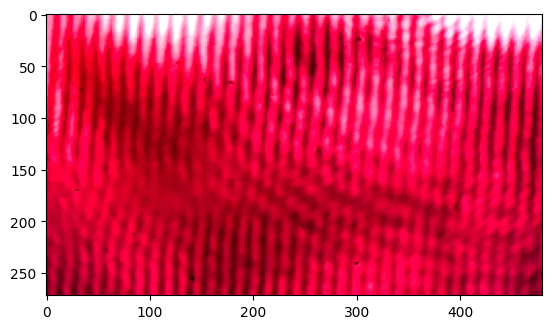

In [92]:
plt.imshow(vidarray[100].astype('uint8'))

In [93]:
# Taking vertical fringes
xmin = 250
xmax = 255
ymin = 30
ymax= 60
vidarraycropped = np.zeros((numberofframes,ymax-ymin,xmax-xmin,3))
for i in range(numberofframes):
  vidarraycropped[i] = vidarray[i][ymin:ymax,xmin:xmax,:]

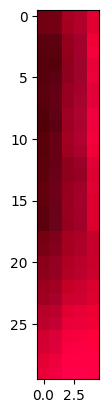

In [94]:
plt.imshow(vidarraycropped[50].astype('uint8'))

In [95]:
sumarr = np.zeros(numberofframes)
shape = np.shape(vidarraycropped)
for i in range(shape[0]):
  for j in range(shape[1]):
    for k in range(shape[2]):
      for l in range(shape[3]):
        sumarr[i] += vidarraycropped[i][j][k][l]

In [103]:
sumarr /= np.max(sumarr)
dc_offset = np.mean(sumarr)

# Subtract the mean from the signal to remove the DC offset
signal_without_dc = sumarr - dc_offset
sumarr = signal_without_dc
index= np.linspace(0,numberofframes,1)
framerate = 29.79 # per sec
timeperiod = 1/framerate #sec
times = np.linspace(0, numberofframes*timeperiod, numberofframes)
# matplotlib.axes.Axes.fill_between(index,sumarr, 'red')

[ 0.82222254  8.67867078 -1.97293481 -0.00950594]


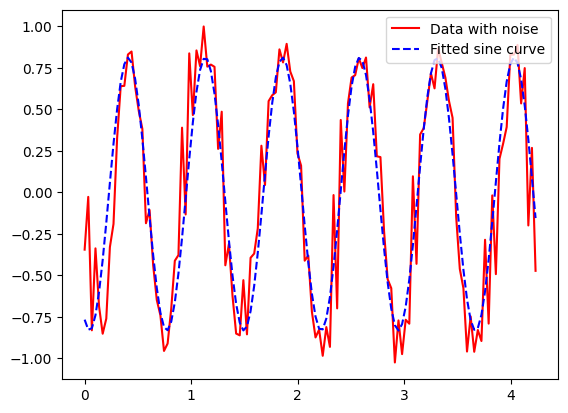

Amplitude: 0.8222225406087629
Frequency: 1.381253353812472
Phase: -113.04083795279203
Offset: -0.009505938323294298


In [109]:
def test(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

params, params_covariance = optimize.curve_fit(test, times, sumarr, p0=[0.25,2*np.pi*1.35,0, 0])

ans = params[0] * np.sin(params[1] * times + params[2]) + params[3]
print(params)
plt.plot(times, sumarr, '-', color='red', label="Data with noise")
#plt.scatter(times, sumarr)
plt.plot(times, ans, '--', color='blue', label="Fitted sine curve")
plt.legend()
plt.show()

Amplitudes = params[0]
Frequency = params[1]
Phase = params[2]
Offset = params[3]

print("Amplitude:", Amplitudes)
print("Frequency:", Frequency/(2*np.pi))
print("Phase:", Phase*(180/np.pi))
print("Offset:", Offset)


Major frequency components (in descending order of magnitude):
Frequency: -1.41 Hz, Magnitude: 50.94
Frequency: 1.41 Hz, Magnitude: 50.94
Frequency: -1.17 Hz, Magnitude: 11.51
Frequency: 1.17 Hz, Magnitude: 11.51
Frequency: -13.37 Hz, Magnitude: 10.52
Frequency: 13.37 Hz, Magnitude: 10.52
Frequency: 1.64 Hz, Magnitude: 7.14
Frequency: -1.64 Hz, Magnitude: 7.14
Frequency: 10.55 Hz, Magnitude: 6.23
Frequency: -10.55 Hz, Magnitude: 6.23


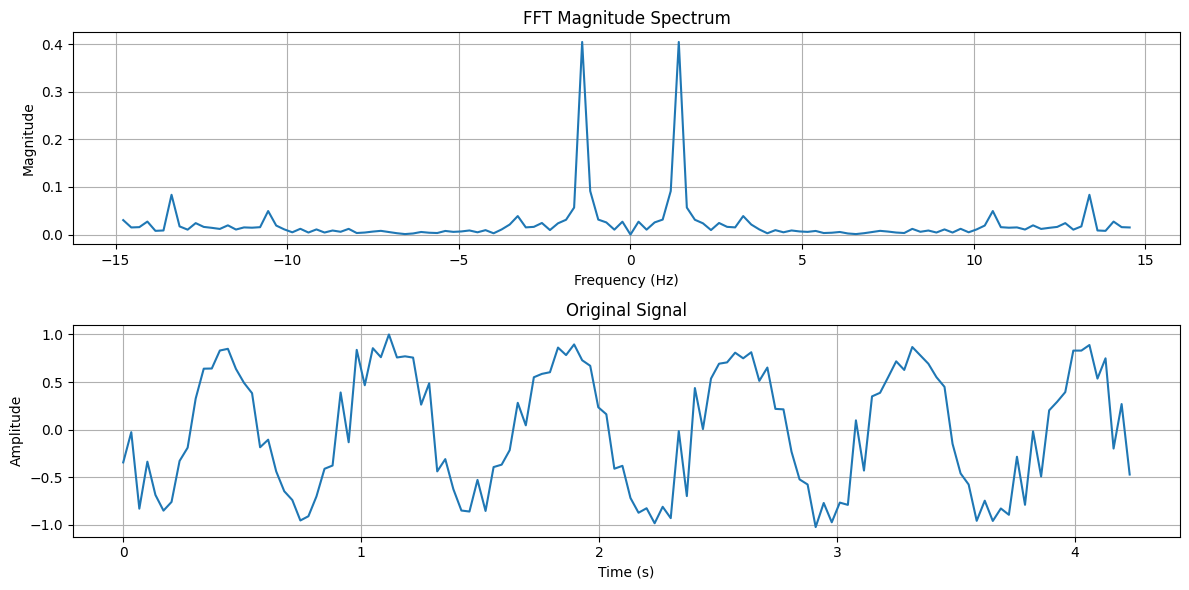

In [110]:
from scipy.fft import fft, fftfreq, fftshift
import numpy as np
import matplotlib.pyplot as plt


N = len(times)

T = times[1] - times[0]


yf = fft(sumarr)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

magnitude = np.abs(yplot)


num_major_components = 10
indices = np.argsort(magnitude)[-num_major_components:]

print("Major frequency components (in descending order of magnitude):")
for i in range(num_major_components):
    freq = xf[indices[-(i + 1)]]
    mag = magnitude[indices[-(i + 1)]]
    print(f"Frequency: {freq:.2f} Hz, Magnitude: {mag:.2f}")


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(xf, 1.0/N * magnitude)
plt.title("FFT Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(times, sumarr)
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()


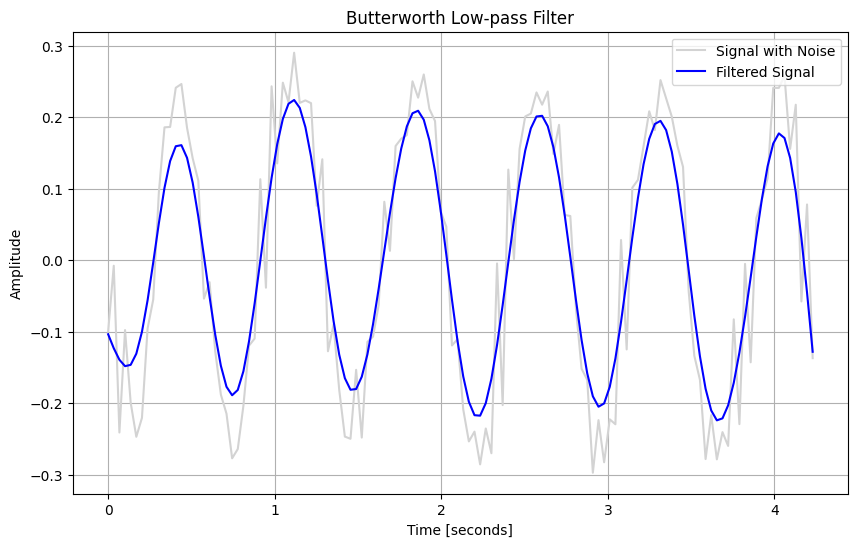

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# LPF Butterworth filter parameters
T = times[-1]         # Sample Period
fs = framerate        # sample rate, Hz
cutoff = 2           # desired cutoff frequency of the filter, Hz
nyq = 0.5 * fs        # Nyquist Frequency
order = 2             # Order of the filter
n = int(T * fs)       # total number of samples

# Define Butterworth Lowpass Filter function
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq  # Normalized cutoff frequency
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)  # Apply the filter
    return y

# Filter the data
filtered_signal = butter_lowpass_filter(sumarr, cutoff, fs, order)
[a,b,c,d,e] = [0.1,0.5,6,0,0]


ans_ = 2* a * np.cos((b+c) * times + d) * np.cos((b-c) * times + e)
#plt.plot(times, sumarr, '-', color='red', label="Data with noise")
#plt.scatter(times, sumarr)


# Plot the original signal and the filtered signal
plt.figure(figsize=(10, 6))

# Plot the original noisy signal
plt.plot(times, sumarr, label='Signal with Noise', linestyle='-', color='lightgray')

# Plot the filtered signal
plt.plot(times, filtered_signal, label='Filtered Signal', linestyle='-', color='blue')

#plt.plot(times, ans_, '-', color='green', label="Fitted sine curve")

# Add labels and title
plt.title('Butterworth Low-pass Filter')
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')

# Add a legend
plt.legend()

# Display the grid
plt.grid()

# Show the plot
plt.show()
